In [3]:
import pandas as pd
from pyopenms import MzMLFile, MSExperiment, OnDiscMSExperiment
import numpy as np
import re
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [4]:
mod_acetyl = ("acetyl","K(UniMod:1)")
mod_biotin = ("biotin","K(UniMod:3)")
mod_dimethyl = ("dimethyl","K(UniMod:36)")
mod_hydroxy = ("hydroxy","P(UniMod:35)")
mod_oxid = ("oxid","P(UniMod:35)")
mod_methyl = ("methyl","K(UniMod:34)")
mod_nitro = ("nitro","Y(UniMod:354)")
mod_phospho = ("phospho","Y(UniMod:21)")

In [5]:
def fix_decoy_report(df):
    df.loc[:, "Q.Value"] = pd.to_numeric(df["Precursor.Id"])
    df.loc[:, "Precursor.Id"] = df["Modified.Sequence"]
    df.loc[:, "CScore"] = df["RT.Start"]

In [6]:
def fdrs_for_cscores(targets_df, decoys_df):
    fdrs = []
    cscores = np.sort(np.concatenate([decoys_df["CScore"], targets_df["CScore"]]))[::-1]

    for cscore in cscores:
        fdr = (decoys_df["CScore"] > cscore).sum() / (targets_df["CScore"] > cscore).sum()
        fdrs.append(fdr)
    return fdrs, cscores

In [7]:
def get_mods_unmods_all_from_splits(result_dir, mods):
    mods_windows_results = {}
    for mod_name, mod_unimod in mods:
        df_mod_windows_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")

        # to account for mismatching columns in result tsv for decoys
        df_mod_windows_subset_decoys = df_mod_windows_subset[df_mod_windows_subset["Q.Value"].isna()]
        fix_decoy_report(df_mod_windows_subset_decoys)
        
        df_mod_windows_subset_targets = df_mod_windows_subset[~df_mod_windows_subset["Q.Value"].isna()]

        if mod_name == "hydroxy":
            mod_name = "oxid"
        mods_windows_results[(mod_name, mod_unimod)] = {"targets": df_mod_windows_subset_targets, "decoys": df_mod_windows_subset_decoys}
    
    df_unmod_windows_subset = pd.read_csv(f"{result_dir}/report_unmodified.tsv", delimiter="\t")
    # to account for mismatching columns in result tsv for decoys
    df_unmod_windows_subset_decoys = df_unmod_windows_subset[df_unmod_windows_subset["Q.Value"].isna()]
    fix_decoy_report(df_unmod_windows_subset_decoys)
    df_unmod_windows_subset_targets = df_unmod_windows_subset[~df_unmod_windows_subset["Q.Value"].isna()]

    all_mods_windows_targets = pd.concat([mod_result["targets"] for mod_result in mods_windows_results.values()], ignore_index=True)
    all_mods_windows_decoys = pd.concat([mod_result["decoys"] for mod_result in mods_windows_results.values()], ignore_index=True)

    all_targets = pd.concat([all_mods_windows_targets, df_unmod_windows_subset_targets], ignore_index=True)
    all_decoys = pd.concat([all_mods_windows_decoys, df_unmod_windows_subset_decoys], ignore_index=True)

    return mods_windows_results, all_mods_windows_targets, all_mods_windows_decoys, df_unmod_windows_subset_targets, df_unmod_windows_subset_decoys, all_targets, all_decoys

In [11]:
def get_targets_decoys_from_all_spectra(result_file):
    df_all_spectra = pd.read_csv(result_file, delimiter="\t")

    # to account for mismatching columns in result tsv for decoys
    df_all_spectra_decoys = df_all_spectra[df_all_spectra["Q.Value"].isna()]
    fix_decoy_report(df_all_spectra_decoys)
    
    df_all_spectra_targets = df_all_spectra[~df_all_spectra["Q.Value"].isna()]

    return df_all_spectra_targets, df_all_spectra_decoys

In [10]:
def plot_densities(targets_df, decoys_df, fig_name=None):
    plt.figure()
    decoys_df["CScore"].plot.kde(label="decoys")
    targets_df["CScore"].plot.kde(label="targets")
    plt.xlabel("CScore")
    plt.legend()

    if fig_name is not None:
        plt.savefig(f"../../data/plots/Cscore_densities_{fig_name}.png", bbox_inches="tight")

In [12]:
mods_windows_results_mod, all_mods_windows_targets_mod, all_mods_windows_decoys_mod, all_unmods_windows_targets_mod, all_unmods_windows_decoys_mod, all_targets_mod, all_decoys_mod = get_mods_unmods_all_from_splits(
    "../../data/workflow_test_tolerance_snr3_10ppm_all_mods_with_decoys",
    [mod_acetyl, mod_biotin, mod_dimethyl, mod_hydroxy, mod_methyl, mod_nitro, mod_phospho])

/tmp/ipykernel_133062/1825828534.py:4: DtypeWarning: Columns (5,11,12,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mod_windows_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")
/tmp/ipykernel_133062/1825828534.py:4: DtypeWarning: Columns (5,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mod_windows_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")
/tmp/ipykernel_133062/1825828534.py:16: DtypeWarning: Columns (5,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_unmod_windows_subset = pd.read_csv(f"{result_dir}/report_unmodified.tsv", delimiter="\t")


In [13]:
fdrs_mod, cscores_mod = fdrs_for_cscores(all_targets_mod, all_decoys_mod)

/tmp/ipykernel_133062/1445082166.py:6: RuntimeWarning: invalid value encountered in scalar divide
  fdr = (decoys_df["CScore"] > cscore).sum() / (targets_df["CScore"] > cscore).sum()


Text(0, 0.5, 'FDR')

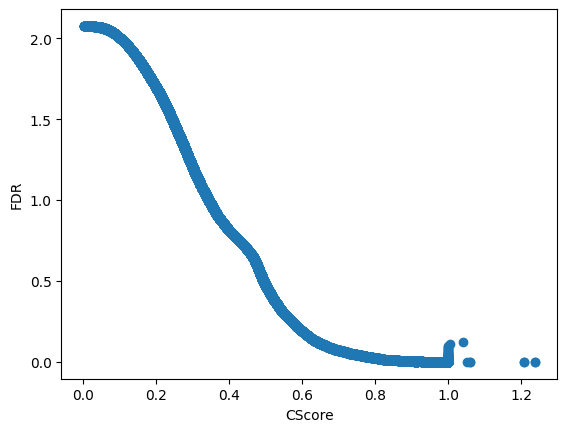

In [10]:
plt.scatter(cscores_mod, fdrs_mod)
plt.xlabel("CScore")
plt.ylabel("FDR")

In [20]:
cscore_1_percent_fdr_mod = np.array(cscores_mod)[np.array(fdrs_mod) <= 0.01].min()
cscore_1_percent_fdr_mod

0.849369

In [12]:
for mod_name, mod_unimod in [mod_acetyl, mod_biotin, mod_dimethyl, mod_oxid, mod_methyl, mod_nitro, mod_phospho]:
    print(mod_name)
    print(all_mods_windows_targets_mod[all_mods_windows_targets_mod["CScore"] >= cscore_1_percent_fdr_mod]["Modified.Sequence"].str.contains(re.escape(mod_unimod)).sum())

acetyl
316
biotin
87
dimethyl
10
oxid
580
methyl
387
nitro
156
phospho
271


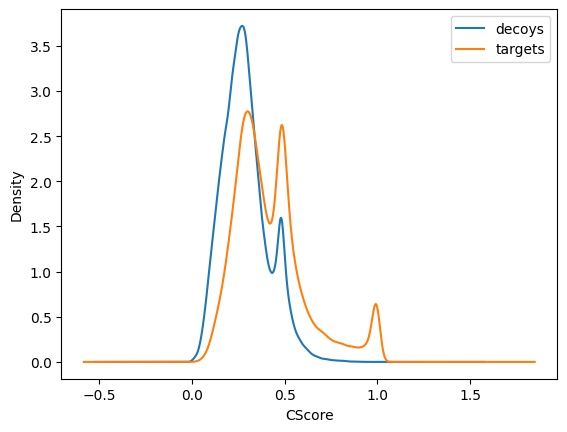

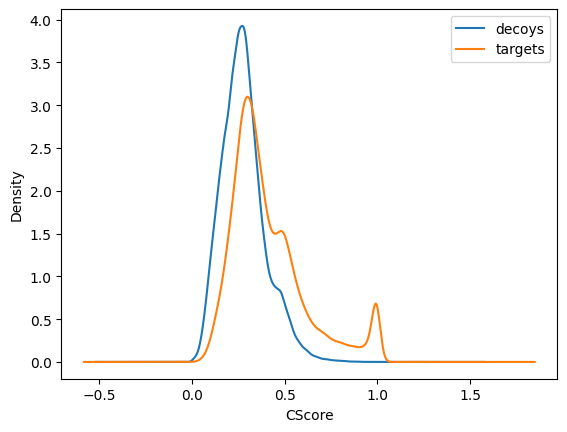

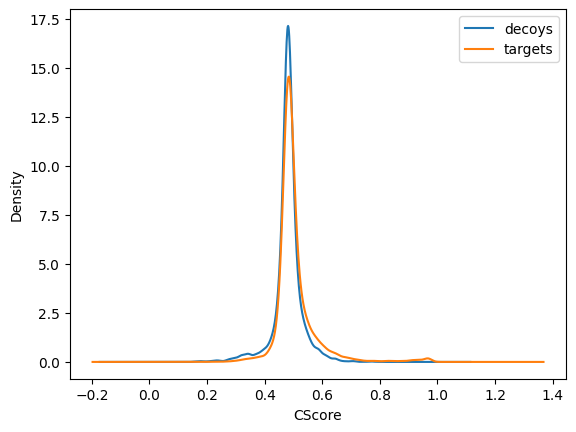

In [13]:
plot_densities(all_targets_mod, all_decoys_mod, fig_name="all_targets_and_decoys_mod_dataset")
plot_densities(all_mods_windows_targets_mod, all_mods_windows_decoys_mod, fig_name="mod_windows_targets_and_decoys_mod_dataset")
plot_densities(all_unmods_windows_targets_mod, all_unmods_windows_decoys_mod, fig_name="unmod_windows_targets_and_decoys_mod_dataset")

# plt.hist(all_decoys["CScore"], bins=np.arange(0, 1.5, 0.01), label="decoys")
# plt.hist(all_targets["CScore"], bins=np.arange(0, 1.5, 0.01), label="targets", alpha=0.8)

In [14]:
mods_windows_results_unmod, all_mods_windows_targets_unmod, all_mods_windows_decoys_unmod, all_unmods_windows_targets_unmod, all_unmods_windows_decoys_unmod, all_targets_unmod, all_decoys_unmod = get_mods_unmods_all_from_splits(
    "../../data/workflow_test_tolerance_snr3_10ppm_unmod",
    [mod_acetyl, mod_dimethyl, mod_hydroxy, mod_methyl, mod_nitro, mod_phospho])

/tmp/ipykernel_15472/1825828534.py:4: DtypeWarning: Columns (5,11,12,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mod_windows_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")
/tmp/ipykernel_15472/1825828534.py:4: DtypeWarning: Columns (5,14,15,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mod_windows_subset = pd.read_csv(f"{result_dir}/report_{mod_unimod}.tsv", delimiter="\t")
/tmp/ipykernel_15472/1825828534.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_mods_windows_targets = pd.concat([mod_result["targets"] for mod_result in mods_windows_results.values()], ignore_index=True)
/tmp/ipykernel_15472/1825828534.py

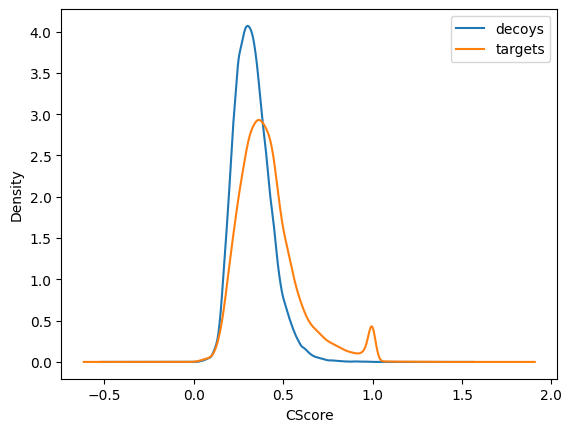

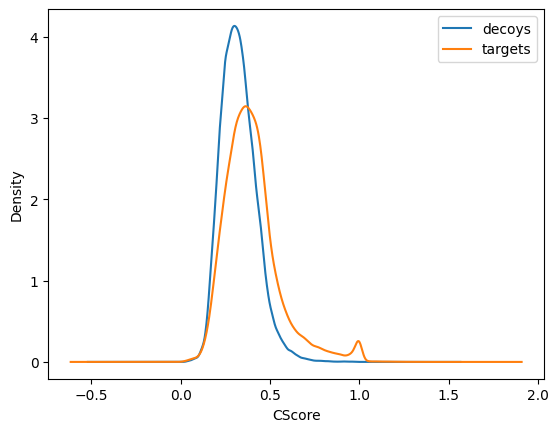

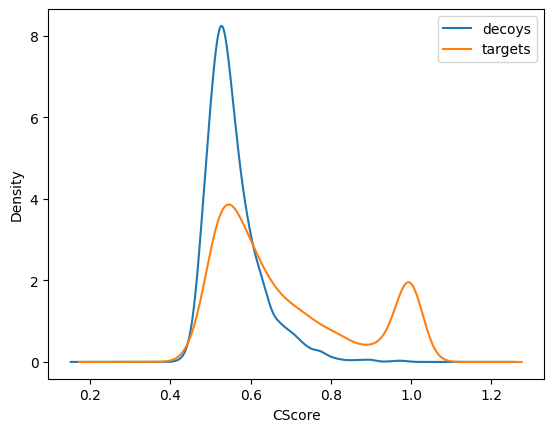

In [15]:
plot_densities(all_targets_unmod, all_decoys_unmod, fig_name="all_targets_and_decoys_unmod_dataset")
plot_densities(all_mods_windows_targets_unmod, all_mods_windows_decoys_unmod, fig_name="mod_windows_targets_and_decoys_unmod_dataset")
plot_densities(all_unmods_windows_targets_unmod, all_unmods_windows_decoys_unmod, fig_name="unmod_windows_targets_and_decoys_unmod_dataset")

In [16]:
len(all_decoys_mod)

181410

In [17]:
fdrs_unmod, cscores_unmod = fdrs_for_cscores(all_targets_unmod, all_decoys_unmod)

/tmp/ipykernel_15472/1445082166.py:6: RuntimeWarning: invalid value encountered in scalar divide
  fdr = (decoys_df["CScore"] > cscore).sum() / (targets_df["CScore"] > cscore).sum()


Text(0, 0.5, 'FDR')

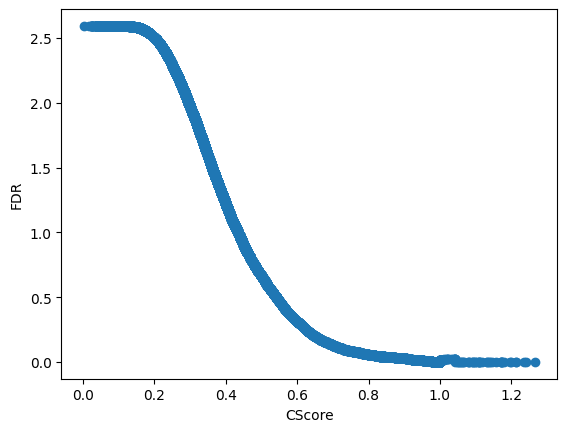

In [18]:
plt.scatter(cscores_unmod, fdrs_unmod)
plt.xlabel("CScore")
plt.ylabel("FDR")

In [19]:
cscore_1_percent_fdr_unmod = np.array(cscores_unmod)[np.array(fdrs_unmod) <= 0.01].min()
cscore_1_percent_fdr_unmod

0.955093

In [20]:
for mod_name, mod_unimod in [mod_acetyl, mod_dimethyl, mod_oxid, mod_methyl, mod_nitro, mod_phospho]:
    print(mod_name)
    print(all_mods_windows_targets_unmod[all_mods_windows_targets_unmod["CScore"] >= cscore_1_percent_fdr_unmod]["Modified.Sequence"].str.contains(re.escape(mod_unimod)).sum())

acetyl
28
dimethyl
0
oxid
0
methyl
1
nitro
0
phospho
0


In [21]:
(all_targets_unmod[all_targets_unmod["CScore"] >= cscore_1_percent_fdr_unmod]["Modified.Sequence"].str.contains("UniMod")).sum()

29

In [22]:
(all_targets_mod[all_targets_mod["CScore"] >= cscore_1_percent_fdr_mod]["Modified.Sequence"].str.contains("UniMod")).sum()

1807

In [23]:
(all_targets_mod["CScore"] >= cscore_1_percent_fdr_mod).sum()

4753

In [24]:
(all_targets_unmod["CScore"] >= cscore_1_percent_fdr_unmod).sum()

1378

In [25]:
def plot_mods_result_mod_dataset_vs_unmod_dataset(mod_targets, unmod_targets, cscore_threshold_mod, cscore_threshold_unmod):
    mod_names = []
    nums_mod_dataset_precursors = []
    nums_unmod_dataset_precursors = []

    for mod_name, mod_unimod in [mod_acetyl, mod_dimethyl, mod_oxid, mod_methyl, mod_nitro, mod_phospho]:
        mod_names.append(mod_name)
        nums_mod_dataset_precursors.append(mod_targets[mod_targets["CScore"] >= cscore_threshold_mod]["Modified.Sequence"].str.contains(re.escape(mod_unimod)).sum())
        nums_unmod_dataset_precursors.append(unmod_targets[unmod_targets["CScore"] >= cscore_threshold_unmod]["Modified.Sequence"].str.contains(re.escape(mod_unimod)).sum())

    x = np.arange(len(mod_names))
    width = 0.25

    fig, ax = plt.subplots()

    ax.bar_label(ax.bar(x, nums_mod_dataset_precursors, width, label="dataset with mods"), padding=3)

    ax.bar_label(ax.bar(x + width, nums_unmod_dataset_precursors, width, label="dataset without mods"), padding=3)

    ax.set_ylabel('Number of found precursors with modifications')
    #ax.set_title(f"Number of detected diagnostic ions for different {xlabel}")
    ax.set_xticks(x + width/2, mod_names)
    ax.legend(loc="upper right")
    #ax.set_ylim(0, 250)

    plt.savefig(f"../../data/plots/all_mods_split_aggregation_mod_unmod_dataset.png", bbox_inches="tight")
    plt.show()


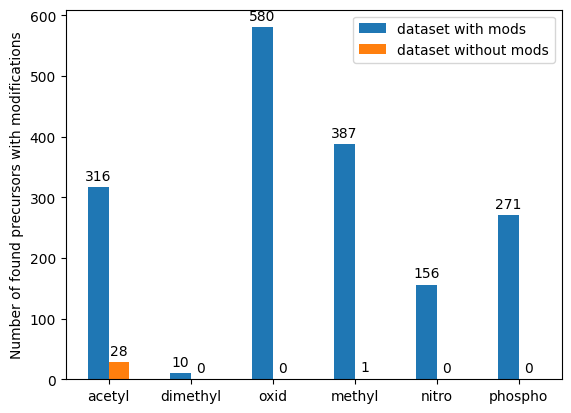

In [26]:
plot_mods_result_mod_dataset_vs_unmod_dataset(all_targets_mod, all_targets_unmod, cscore_1_percent_fdr_mod, cscore_1_percent_fdr_unmod)

In [23]:
targets_all_spectra, decoys_all_spectra = get_targets_decoys_from_all_spectra("../../data/diann_results/dia_nn_results_filtered/report_filtered_5mods_together_all_spectra.tsv")

In [29]:
fdrs_all_spectra, cscores_all_spectra = fdrs_for_cscores(targets_all_spectra, decoys_all_spectra)

/tmp/ipykernel_15472/1445082166.py:6: RuntimeWarning: invalid value encountered in scalar divide
  fdr = (decoys_df["CScore"] > cscore).sum() / (targets_df["CScore"] > cscore).sum()


In [30]:
cscore_1_percent_fdr_all_spectra = np.array(cscores_all_spectra)[np.array(fdrs_all_spectra) <= 0.01].min()
cscore_1_percent_fdr_all_spectra

0.886603

In [31]:
(decoys_all_spectra["CScore"] > cscore_1_percent_fdr_all_spectra).sum() / (targets_all_spectra["CScore"] > cscore_1_percent_fdr_all_spectra).sum()

0.00990693485439808

In [32]:
(decoys_all_spectra["CScore"] > cscore_1_percent_fdr_all_spectra).sum(), (targets_all_spectra["CScore"] > cscore_1_percent_fdr_all_spectra).sum()

(33, 3331)

In [33]:
(decoys_all_spectra["Q.Value"] < 0.01).sum() / (targets_all_spectra["Q.Value"] < 0.01).sum()

0.01020714500150105

In [34]:
(decoys_all_spectra["Q.Value"] < 0.01).sum(), (targets_all_spectra["Q.Value"] < 0.01).sum()

(34, 3331)

In [17]:
def get_num_single_mod_and_combinations(df_for_mod, mod_unimod):
    assert df_for_mod["Modified.Sequence"].str.contains(re.escape(mod_unimod)).sum() == len(df_for_mod)
    unimod_regex = re.compile(r".\(UniMod:[0-9]+\)")
    num_single = 0
    num_combination = 0
    for sequence in df_for_mod["Modified.Sequence"]:
        mods = np.unique(re.findall(unimod_regex, sequence))
        if len(mods) == 1:
            num_single += 1
        else:
            num_combination += 1
    return num_single, num_combination


In [90]:
def plot_all_spectra_vs_subset(
    mod_targets_subset, cscore_threshold_mod, targets_all_spectra
):
    mod_names = []
    nums_subset_mod_precursors_single = []
    nums_subset_mod_precursors_combination = []
    nums_all_mod_precursors_single = []
    nums_all_mod_precursors_combination = []

    for mod_name, mod_unimod in [
        mod_acetyl,
        mod_dimethyl,
        mod_oxid,
        mod_methyl,
        mod_nitro,
        mod_phospho,
    ]:
        mod_names.append(mod_name)
        num_subset_mod_precursors_single, num_subset_mod_precursors_combination = (
            get_num_single_mod_and_combinations(
                mod_targets_subset[
                    np.logical_and(
                        mod_targets_subset["CScore"] >= cscore_threshold_mod,
                        mod_targets_subset["Modified.Sequence"].str.contains(
                            re.escape(mod_unimod)
                        ),
                    )
                ],
                mod_unimod,
            )
        )
        nums_subset_mod_precursors_single.append(num_subset_mod_precursors_single)
        nums_subset_mod_precursors_combination.append(num_subset_mod_precursors_combination)

        num_all_mod_precursors_single, num_all_mod_precursors_combination = (
            get_num_single_mod_and_combinations(
                targets_all_spectra[
                    np.logical_and(
                        targets_all_spectra["Q.Value"] < 0.01,
                        targets_all_spectra["Modified.Sequence"].str.contains(
                            re.escape(mod_unimod)
                        ),
                    )
                ],
                mod_unimod,
            )
        )
        nums_all_mod_precursors_single.append(num_all_mod_precursors_single)
        nums_all_mod_precursors_combination.append(num_all_mod_precursors_combination)

    x = np.arange(len(mod_names))
    width = 0.25

    fig, ax = plt.subplots()
    # bottom = np.zeros(len(mod_names))

    # for window_boolean, mod_count in stacked_bars.items():
    #     p = ax.bar(mod_names, mod_count, width, label=window_boolean, bottom=bottom)
    #     bottom += mod_count

    def print_nonzero_labels(labels):
        labels = np.array(labels).astype(str)
        labels[labels == "0"] = ""
        return labels

    ax.bar_label(
        ax.bar(x, nums_all_mod_precursors_single, width, label="search in all spectra\n- occurs alone", color="#00004B"),
        padding=3,
    )
    ax.bar_label(
        ax.bar(
            x,
            nums_all_mod_precursors_combination,
            width,
            bottom=nums_all_mod_precursors_single,
            label="search in all spectra\n- occurs in comb.", color="#B0C0FF"
        ),
        padding=3, labels=print_nonzero_labels(nums_all_mod_precursors_combination)
    )

    ax.bar_label(
        ax.bar(
            x + width+0.05,
            nums_subset_mod_precursors_single,
            width,
            label="search in mod\nion windows\n- occurs alone",
            color="#9F3400"
        ),
        padding=3,
    )
    ax.bar_label(
        ax.bar(
            x + width+0.05,
            nums_subset_mod_precursors_combination,
            width,
            bottom=nums_subset_mod_precursors_single,
            label="search in mod\nion windows\n- occurs in comb.",
            color="#FF935F"
        ), labels=print_nonzero_labels(nums_subset_mod_precursors_combination),
        padding=3,
    )

    ax.set_ylabel("Number of found precursors with modifications")
    # ax.set_title(f"Number of detected diagnostic ions for different {xlabel}")
    ax.set_xticks(x + width / 2, mod_names)
    ax.legend(loc="upper right")
    # ax.set_ylim(0, 250)

    plt.savefig(f"../../data/plots/all_mods_together_split_aggregation_vs_all_spectra.png", bbox_inches="tight")
    plt.show()

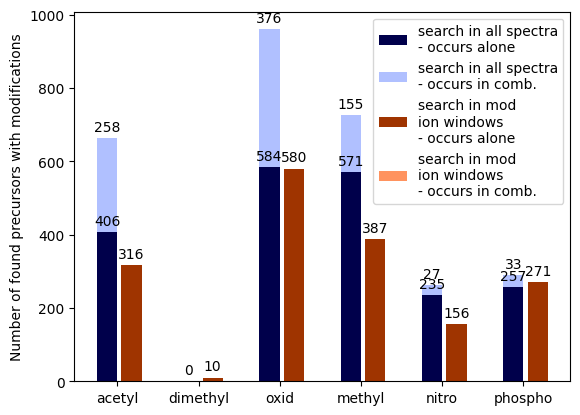

In [91]:
plot_all_spectra_vs_subset(all_targets_mod, cscore_1_percent_fdr_mod, targets_all_spectra)